In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../dataset/spx.csv")
df.head()

,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


In [2]:
import numpy as np

def add_log_returns(df, price_col="close"):
    """
    Adds a log-return column to the dataframe:
    log_return[t] = log(price[t] / price[t-1])
    """
    df = df.copy()
    df["log_return"] = np.log(df[price_col] / df[price_col].shift(1))
    return df

# Example:
df = add_log_returns(df)
df = df.dropna(subset=["log_return"])
df.head()

,date,close,log_return
1,03-Jan-86,210.88,0.006136
2,06-Jan-86,210.65,-0.001091
3,07-Jan-86,213.80,0.014843
4,08-Jan-86,207.97,-0.027647
5,09-Jan-86,206.11,-0.008984


In [3]:
WINDOW_SIZE = 5

def window_df(df, window_size=WINDOW_SIZE):
    dfw = df.copy().reset_index(drop=True)

    window_size = 5

    records = []
    for i in range(len(dfw)//window_size):
        if window_size*(i+1) > len(dfw):
            continue
        window = dfw.iloc[window_size*i:window_size*(i+1)]
        records.append({"dates": [*window["date"]], "closes": [*window["close"]], "log_returns": [*window["log_return"]]})
    return pd.DataFrame.from_records(records)
df_5 = window_df(df)
df_5.head()

,dates,closes,log_returns
0,"[03-Jan-86, 06-Jan-86, 07-Jan-86, 08-Jan-86, 0...","[210.88, 210.65, 213.8, 207.97, 206.11]","[0.006136009929073977, -0.0010912628891168634,..."
1,"[10-Jan-86, 13-Jan-86, 14-Jan-86, 15-Jan-86, 1...","[205.96, 206.72, 206.64, 208.26, 209.17]","[-0.0007280316772654538, 0.003683245416296368,..."
2,"[17-Jan-86, 20-Jan-86, 21-Jan-86, 22-Jan-86, 2...","[208.43, 207.53, 205.79, 203.49, 204.25]","[-0.0035440650122491265, -0.004327345920010411..."
3,"[24-Jan-86, 27-Jan-86, 28-Jan-86, 29-Jan-86, 3...","[206.43, 207.39, 209.81, 210.29, 209.33]","[0.010616638142385991, 0.0046397067427851255, ..."
4,"[31-Jan-86, 03-Feb-86, 04-Feb-86, 05-Feb-86, 0...","[211.78, 213.96, 212.79, 212.96, 213.47]","[0.011636045895879665, 0.010241081660741048, -..."


In [4]:
from itertools import accumulate

def label_windows(dfw, threshold):
    labels = []
    for i in range(len(dfw)):
        if i == (len(dfw) - 1):
            labels.append(None)
            continue

        #current_window = dfw["log_returns"].iloc[i]
        next_window = dfw["log_returns"].iloc[i+1]
        cummulative_sums = accumulate(next_window)
        flag = False
        for x in cummulative_sums:
            if x > threshold:
                labels.append("BUY")
                flag = True
                break
            if x < -threshold:
                labels.append("SELL")
                flag = True
                break
        if not flag:
            labels.append("NEUTRAL")
    return pd.Series(labels)

df_5["label"] = label_windows(df_5, threshold=0.01) # a bit more than 1%
df_5 = df_5.dropna(subset=["label"])
df_5.head()

,dates,closes,log_returns,label
0,"[03-Jan-86, 06-Jan-86, 07-Jan-86, 08-Jan-86, 0...","[210.88, 210.65, 213.8, 207.97, 206.11]","[0.006136009929073977, -0.0010912628891168634,...",BUY
1,"[10-Jan-86, 13-Jan-86, 14-Jan-86, 15-Jan-86, 1...","[205.96, 206.72, 206.64, 208.26, 209.17]","[-0.0007280316772654538, 0.003683245416296368,...",SELL
2,"[17-Jan-86, 20-Jan-86, 21-Jan-86, 22-Jan-86, 2...","[208.43, 207.53, 205.79, 203.49, 204.25]","[-0.0035440650122491265, -0.004327345920010411...",BUY
3,"[24-Jan-86, 27-Jan-86, 28-Jan-86, 29-Jan-86, 3...","[206.43, 207.39, 209.81, 210.29, 209.33]","[0.010616638142385991, 0.0046397067427851255, ...",BUY
4,"[31-Jan-86, 03-Feb-86, 04-Feb-86, 05-Feb-86, 0...","[211.78, 213.96, 212.79, 212.96, 213.47]","[0.011636045895879665, 0.010241081660741048, -...",BUY


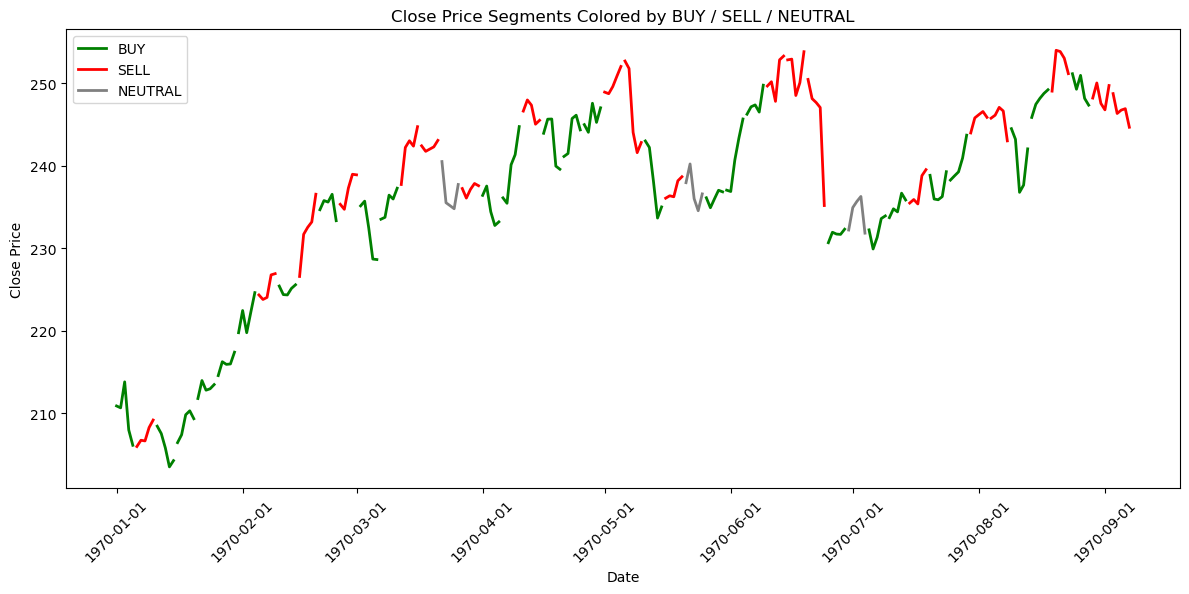

In [5]:
import matplotlib.dates as mdates


used_labels = set()

color_map = {
    "BUY": "green",
    "SELL": "red",
    "NEUTRAL": "gray"
}

plt.figure(figsize=(12,6))

for idx, row in df_5.iloc[:50].iterrows():
    dates = row['dates']
    closes = row['closes']
    label = row['label']

    # add label only once
    legend_label = label if label not in used_labels else None
    used_labels.add(label)

    plt.plot(dates, closes, color=color_map[label], label=legend_label, linewidth=2)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Segments Colored by BUY / SELL / NEUTRAL")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()


In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import resample


def build_sequences_variable_length(
    df_tokens,
    min_len=9,
    max_len=52,
    stride=1,
    balance=True,
    random_state=42
):
    """
    Build variable-length overlapping sequences from token dataframe.

    df_tokens: dataframe with columns "log_returns" (list) and "label"
    min_len: minimum number of tokens per sequence
    max_len: maximum number of tokens per sequence
    stride: shift between starting points of sequences
    balance: if True → balance dataset by last-token label
    """

    sequences = []
    N = len(df_tokens)

    rng = np.random.default_rng(random_state)

    for start in tqdm(range(0, N - min_len, stride)):
        # choose a random length L for this sequence
        L = rng.integers(min_len, max_len + 1)

        end = start + L
        if end > N:
            break  # cannot build a sequence longer than available tokens

        # Extract tokens and label
        seq_tokens = df_tokens["log_returns"].iloc[start:end].tolist()
        seq_labels = df_tokens["label"].iloc[start:end].tolist()
        last_label = seq_labels[-1]
        start_date = df_tokens["dates"].iloc[start][0]
        end_date = df_tokens["dates"].iloc[end - 1][-1]

        sequences.append({
            "sequence": seq_tokens,
            "labels": seq_labels,
            "last_label": last_label,
            "start_date": start_date,
            "end_date": end_date,
            "length": L
        })

    sequences_df = pd.DataFrame(sequences)
    
    # -----------------------------
    # Balance by final-token label
    # -----------------------------
    if balance:
        groups = sequences_df.groupby("last_label")
        min_size = groups.size().min()

        balanced = []
        for label, group in groups:
            balanced.append(group.sample(min_size, random_state=random_state))
        sequences_df = pd.concat(balanced).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return sequences_df

In [7]:
df_data = build_sequences_variable_length(df_5)
df_data

 98%|█████████▊| 1598/1628 [00:00<00:00, 18367.54it/s]


,sequence,labels,last_label,start_date,end_date,length
0,"[[-0.02077213936559749, 0.02511612495934869, 0...","[SELL, BUY, BUY, SELL, BUY, SELL, BUY, BUY, SE...",BUY,17-Dec-87,05-Apr-88,15
1,"[[-0.00193592515470274, 0.001300770414770671, ...","[SELL, BUY, BUY, BUY, SELL, BUY, SELL, NEUTRAL...",BUY,02-Apr-08,21-Aug-08,20
2,"[[-0.008272468062764627, -0.004625558908068005...","[NEUTRAL, NEUTRAL, BUY, SELL, NEUTRAL, SELL, B...",BUY,20-Sep-93,12-Jul-94,41
3,"[[0.011201440230341963, -0.0032760215377244046...","[BUY, BUY, BUY, BUY, NEUTRAL, BUY, SELL, NEUTR...",SELL,01-Dec-03,29-Jun-04,29
4,"[[-0.003742993668069835, 0.0003737441794290525...","[SELL, SELL, NEUTRAL, SELL, BUY, BUY, BUY, SEL...",NEUTRAL,29-Jul-13,02-Jan-14,22
...,...,...,...,...,...,...
1027,"[[-0.001145058158735882, 0.004606946266200653,...","[SELL, SELL, BUY, BUY, BUY, BUY, NEUTRAL, SELL...",BUY,01-May-87,27-Oct-87,25
1028,"[[-0.0018136709785938731, 0.001871042227964028...","[NEUTRAL, BUY, NEUTRAL, BUY, NEUTRAL, SELL, NE...",BUY,25-Apr-16,27-Jun-16,9
1029,"[[2.8454898986964683e-05, -0.00227420115252391...","[SELL, NEUTRAL, SELL, BUY, SELL, BUY, SELL, SE...",NEUTRAL,30-Jul-15,03-Mar-16,30
1030,"[[-0.002087622332874619, 0.013588628383570183,...","[NEUTRAL, SELL, NEUTRAL, BUY, BUY, BUY, NEUTRA...",BUY,23-May-16,18-May-17,50


<h2 style='color:#34495e;'>🔍 Embedding Generation with Chronos</h2>

<p style='font-size:14px; line-height:1.6;'>
The next section loads the <b>Amazon Chronos</b> time-series model and uses it to 
generate embeddings for each sequence. This is a crucial step, because instead of 
training directly on raw log-returns, we transform every token into a 
<b>high-dimensional representation</b> learned from large-scale forecasting tasks.
</p>

<p style='font-size:14px; line-height:1.6;'>
In short:
<ul>
<li>We load a pretrained <b>Chronos-T5-large</b> encoder.</li>
<li>For each variable-length windowed sequence, we feed the flattened values 
    into <code>pipeline.embed()</code>.</li>
<li>We then reconstruct window-level embeddings and create both:
    <ul>
        <li><b>mean-pooled embeddings</b> for each window</li>
        <li><b>last-token embeddings</b> for each window</li>
    </ul>
</li>
<li>These embeddings are the features used for downstream token-level classification.</li>
</ul>
</p>

In [8]:
import torch
from chronos import ChronosPipeline


# ---------------------------------------------------------
# 1. Load Chronos Model (encoder in evaluation mode)
# ---------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    torch_dtype=torch.float16,
    device_map=device,
)
model = pipeline.model
model.eval()


c:\Users\Tuuli\.conda\envs\forecast-chronos\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


ChronosModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(4096, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(4096, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=1024, out_features=4096, bias=False)
                (wo): Linear(

In [9]:
import torch
from tqdm import tqdm
import pandas as pd


device = "cuda" if torch.cuda.is_available() else "cpu"

s_global_mean  = []
s_global_last  = []
s_sub_mean     = []
s_sub_last     = []

with torch.no_grad():
    for subseries_list in tqdm(df_data["sequence"], total=len(df_data)):
        
        # ---------------------------------------------
        # 1) Flatten full sequence → ONE Chronos embed
        # ---------------------------------------------
        full_series = [x for window in subseries_list for x in window]
        full_series = torch.tensor(full_series, dtype=torch.float32)  # KEEP ON CPU!

        # Chronos handles device placement internally
        global_emb, _ = pipeline.embed(full_series)
        global_emb = global_emb.squeeze(0)  # shape: (L, D)

        # ---------------------------------------------
        # 2) Slice global embedding back into windows
        # ---------------------------------------------
        pos = 0
        g_mean_list = []
        g_last_list = []
        s_mean_list = []
        s_last_list = []

        for window in subseries_list:
            wlen = len(window)

            g_slice = global_emb[pos : pos + wlen]
            global_mean = g_slice.mean(dim=0)
            global_last = g_slice[-1]

            s_mean_list.append(global_mean)  # sub == global
            s_last_list.append(global_last)
            g_mean_list.append(global_mean)
            g_last_list.append(global_last)

            pos += wlen

        s_global_mean.append(g_mean_list)
        s_global_last.append(g_last_list)
        s_sub_mean.append(s_mean_list)
        s_sub_last.append(s_last_list)


df_data["global_mean_pooling"]      = pd.Series(s_global_mean)
df_data["global_last_state"]        = pd.Series(s_global_last)
df_data["subseries_mean_pooling"]   = pd.Series(s_sub_mean)
df_data["subseries_last_state"]     = pd.Series(s_sub_last)

df_data.head()


100%|██████████| 1032/1032 [00:28<00:00, 35.63it/s]


,sequence,labels,last_label,start_date,end_date,length,global_mean_pooling,global_last_state,subseries_mean_pooling,subseries_last_state
0,"[[-0.02077213936559749, 0.02511612495934869, 0...","[SELL, BUY, BUY, SELL, BUY, SELL, BUY, BUY, SE...",BUY,17-Dec-87,05-Apr-88,15,"[[tensor(0.0012, dtype=torch.float16), tensor(...","[[tensor(-0.0031, dtype=torch.float16), tensor...","[[tensor(0.0012, dtype=torch.float16), tensor(...","[[tensor(-0.0031, dtype=torch.float16), tensor..."
1,"[[-0.00193592515470274, 0.001300770414770671, ...","[SELL, BUY, BUY, BUY, SELL, BUY, SELL, NEUTRAL...",BUY,02-Apr-08,21-Aug-08,20,"[[tensor(0.0085, dtype=torch.float16), tensor(...","[[tensor(-0.0084, dtype=torch.float16), tensor...","[[tensor(0.0085, dtype=torch.float16), tensor(...","[[tensor(-0.0084, dtype=torch.float16), tensor..."
2,"[[-0.008272468062764627, -0.004625558908068005...","[NEUTRAL, NEUTRAL, BUY, SELL, NEUTRAL, SELL, B...",BUY,20-Sep-93,12-Jul-94,41,"[[tensor(0.0057, dtype=torch.float16), tensor(...","[[tensor(0.0087, dtype=torch.float16), tensor(...","[[tensor(0.0057, dtype=torch.float16), tensor(...","[[tensor(0.0087, dtype=torch.float16), tensor(..."
3,"[[0.011201440230341963, -0.0032760215377244046...","[BUY, BUY, BUY, BUY, NEUTRAL, BUY, SELL, NEUTR...",SELL,01-Dec-03,29-Jun-04,29,"[[tensor(0.0051, dtype=torch.float16), tensor(...","[[tensor(-0.0062, dtype=torch.float16), tensor...","[[tensor(0.0051, dtype=torch.float16), tensor(...","[[tensor(-0.0062, dtype=torch.float16), tensor..."
4,"[[-0.003742993668069835, 0.0003737441794290525...","[SELL, SELL, NEUTRAL, SELL, BUY, BUY, BUY, SEL...",NEUTRAL,29-Jul-13,02-Jan-14,22,"[[tensor(0.0015, dtype=torch.float16), tensor(...","[[tensor(0.0066, dtype=torch.float16), tensor(...","[[tensor(0.0015, dtype=torch.float16), tensor(...","[[tensor(0.0066, dtype=torch.float16), tensor(..."


In [10]:
def flatten_sequence(seq):
    # flatten 1 level: [x] or [ [x] ] → x
    return [x for sub in seq for x in (sub if isinstance(sub, (list, tuple)) else [sub])]

def add_chronos_forecasts(df, column, pipeline, prediction_length=12, new_column="forecast"):
    """
    df: pandas DataFrame
    column: name of the column that contains each time-series (list or tensor)
    """
    forecasts = []

    for series in df[column]:
        # Flatten series (it may contain numbers, lists, or tuples)
        flat = torch.tensor(flatten_sequence(series), dtype=torch.float32)
        # Chronos expects a list of 1D tensors → [ts]
        fc = pipeline.predict([flat], prediction_length)

        # Output shape: [1, num_samples, pred_len]
        fc_single = fc[0].tolist()

        forecasts.append(fc_single)

    df[new_column] = forecasts
    return df


df_data = add_chronos_forecasts(df_data, "sequence", pipeline, prediction_length=12, new_column="forecast")

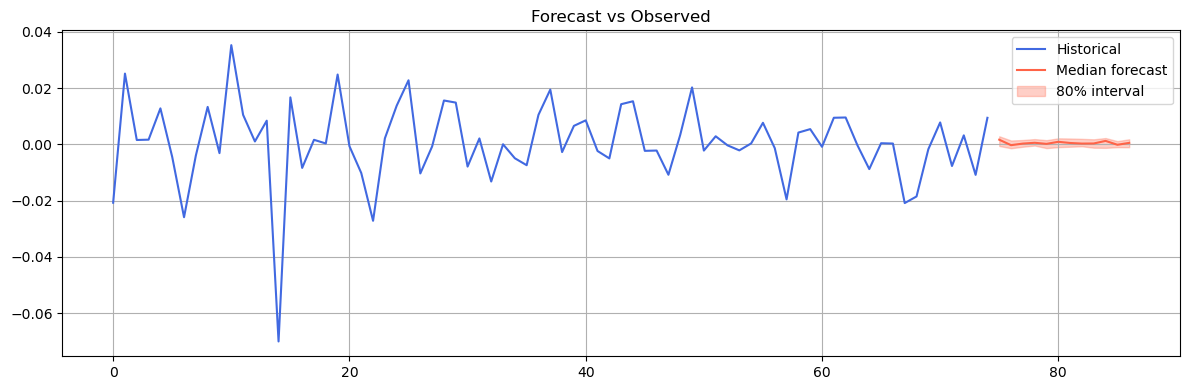

In [11]:
def plot_row_forecast(sequence, forecast, prediction_length=12):
    """
    sequence: list of values OR list of lists (subwindows)
    forecast: [num_samples, prediction_length]
    """

    # --- 1) Flatten sequence if needed ---
    if isinstance(sequence[0], (list, tuple)):
        seq_flat = np.array([v for row in sequence for v in row], dtype=np.float32)
    else:
        seq_flat = np.array(sequence, dtype=np.float32)

    # --- 2) Convert forecast to numpy ---
    forecast = np.array(forecast)  # shape: (num_samples, prediction_length)

    # --- 3) Compute quantiles ---
    low, median, high = np.quantile(forecast, [0.1, 0.5, 0.9], axis=0)

    # --- 4) Build forecast index ---
    forecast_idx = range(len(seq_flat), len(seq_flat) + prediction_length)

    # --- 5) Plot ---
    plt.figure(figsize=(12, 4))

    plt.plot(seq_flat, label="Historical", color="royalblue")
    plt.plot(forecast_idx, median, label="Median forecast", color="tomato")
    plt.fill_between(forecast_idx, low, high, color="tomato", alpha=0.3, label="80% interval")

    plt.title("Forecast vs Observed")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

row = df_data.iloc[0]

plot_row_forecast(
    sequence=row["sequence"],
    forecast=row["forecast"],
    prediction_length=12
)


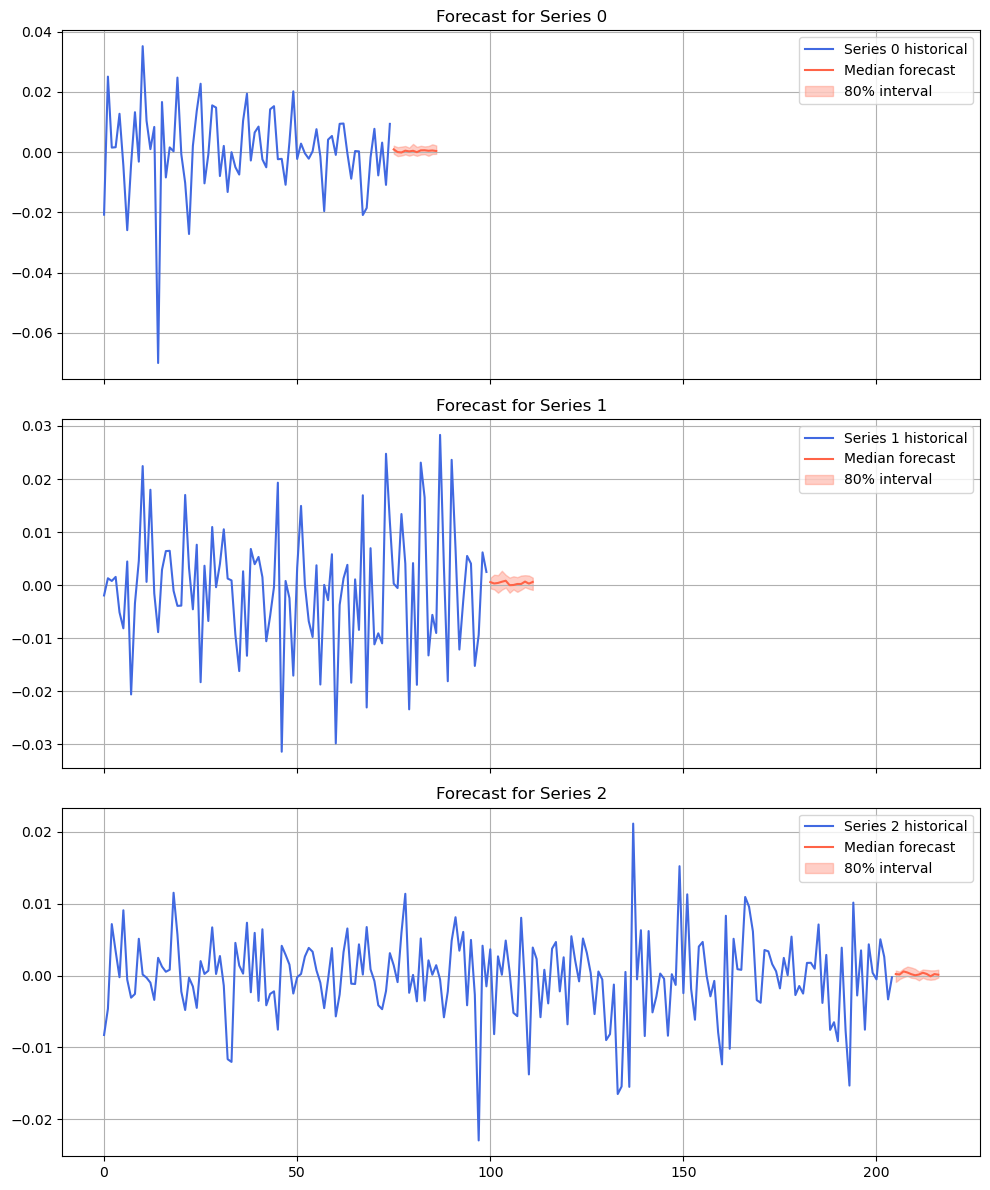

In [12]:

def forecast_chronos(series_list, pipeline, prediction_length=12):
    """
    series_list: list of 1D lists/tensors, each representing a time series.
    prediction_length: how many steps ahead to forecast.
    """
    # Convert all series to float32 tensors (Chronos requirement)
    ts_list = [torch.tensor(series, dtype=torch.float32) for series in series_list]

    n_series = len(ts_list)

    # -----------------------------
    # Forecast: output shape = [num_series, num_samples, prediction_length]
    # -----------------------------
    forecast = pipeline.predict(ts_list, prediction_length)
    return ts_list , n_series, forecast

def plot_forecasts(ts_list, n_series , forecasts, prediction_length = 12):
    # -----------------------------
    # Plot each series
    # -----------------------------
    fig, axes = plt.subplots(n_series, 1, figsize=(10, 4 * n_series), sharex=True)

    # Ensure axes is iterable
    if n_series == 1:
        axes = [axes]

    for i in range(n_series):
        observed = ts_list[i].numpy()
        f = forecasts[i].numpy()  # [num_samples, prediction_length]

        # Compute quantiles
        low, median, high = np.quantile(f, [0.1, 0.5, 0.9], axis=0)

        # x-axis for forecast portion
        forecast_index = range(len(observed), len(observed) + prediction_length)

        ax = axes[i]
        ax.plot(observed, label=f"Series {i} historical", color="royalblue")
        ax.plot(forecast_index, median, label="Median forecast", color="tomato")
        ax.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% interval")

        ax.set_title(f"Forecast for Series {i}")
        ax.grid(True)
        ax.legend()
    plt.tight_layout()
    plt.show()

series_list = [
    [x for sub in seq for x in sub]   # flatten each row
    for seq in df_data["sequence"]
]

ts_list , n_series, forecast = forecast_chronos(series_list[:3], pipeline, prediction_length=12)
plot_forecasts(ts_list, n_series , forecast, prediction_length = 12)


In [13]:
def label_from_forecast_row(forecast_array, threshold):
    """
    forecast_array: numpy array or list of shape [num_samples, pred_len]
                    (the same returned by Chronos)
    """
    median_forecast = np.median(forecast_array, axis=0)

    # Convert median forecast into log-return window (like your original df)
    log_returns = median_forecast  # if these values ARE already log-returns

    # Apply your original label logic but for ONLY ONE ROW
    for cumulative in accumulate(log_returns):
        if cumulative > threshold:
            return "BUY"
        if cumulative < -threshold:
            return "SELL"
    return "NEUTRAL"


def add_forecast_labels(df, forecast_col="forecast", threshold=0.01):
    """
    df: DataFrame with a column containing forecast arrays
    forecast_col: the column where forecast arrays are stored
    """
    labels = []

    for fc in df[forecast_col]:
        # fc is shape: [num_samples, prediction_length]
        label = label_from_forecast_row(fc, threshold)
        labels.append(label)

    df["forecast_label"] = labels
    return df

add_forecast_labels(df_data)

,sequence,labels,last_label,start_date,end_date,length,global_mean_pooling,global_last_state,subseries_mean_pooling,subseries_last_state,forecast,forecast_label
0,"[[-0.02077213936559749, 0.02511612495934869, 0...","[SELL, BUY, BUY, SELL, BUY, SELL, BUY, BUY, SE...",BUY,17-Dec-87,05-Apr-88,15,"[[tensor(0.0012, dtype=torch.float16), tensor(...","[[tensor(-0.0031, dtype=torch.float16), tensor...","[[tensor(0.0012, dtype=torch.float16), tensor(...","[[tensor(-0.0031, dtype=torch.float16), tensor...","[[-0.0009185822564177215, -0.00134254118893295...",NEUTRAL
1,"[[-0.00193592515470274, 0.001300770414770671, ...","[SELL, BUY, BUY, BUY, SELL, BUY, SELL, NEUTRAL...",BUY,02-Apr-08,21-Aug-08,20,"[[tensor(0.0085, dtype=torch.float16), tensor(...","[[tensor(-0.0084, dtype=torch.float16), tensor...","[[tensor(0.0085, dtype=torch.float16), tensor(...","[[tensor(-0.0084, dtype=torch.float16), tensor...","[[0.00012921034067403525, 0.000646051717922091...",NEUTRAL
2,"[[-0.008272468062764627, -0.004625558908068005...","[NEUTRAL, NEUTRAL, BUY, SELL, NEUTRAL, SELL, B...",BUY,20-Sep-93,12-Jul-94,41,"[[tensor(0.0057, dtype=torch.float16), tensor(...","[[tensor(0.0087, dtype=torch.float16), tensor(...","[[tensor(0.0057, dtype=torch.float16), tensor(...","[[tensor(0.0087, dtype=torch.float16), tensor(...","[[-0.00018525149789638817, 0.00033962973975576...",NEUTRAL
3,"[[0.011201440230341963, -0.0032760215377244046...","[BUY, BUY, BUY, BUY, NEUTRAL, BUY, SELL, NEUTR...",SELL,01-Dec-03,29-Jun-04,29,"[[tensor(0.0051, dtype=torch.float16), tensor(...","[[tensor(-0.0062, dtype=torch.float16), tensor...","[[tensor(0.0051, dtype=torch.float16), tensor(...","[[tensor(-0.0062, dtype=torch.float16), tensor...","[[0.000661530822981149, 0.00028942240169271827...",NEUTRAL
4,"[[-0.003742993668069835, 0.0003737441794290525...","[SELL, SELL, NEUTRAL, SELL, BUY, BUY, BUY, SEL...",NEUTRAL,29-Jul-13,02-Jan-14,22,"[[tensor(0.0015, dtype=torch.float16), tensor(...","[[tensor(0.0066, dtype=torch.float16), tensor(...","[[tensor(0.0015, dtype=torch.float16), tensor(...","[[tensor(0.0066, dtype=torch.float16), tensor(...","[[0.0012793088098987937, -3.655398904811591e-0...",NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,"[[-0.001145058158735882, 0.004606946266200653,...","[SELL, SELL, BUY, BUY, BUY, BUY, NEUTRAL, SELL...",BUY,01-May-87,27-Oct-87,25,"[[tensor(0.0095, dtype=torch.float16), tensor(...","[[tensor(0.0029, dtype=torch.float16), tensor(...","[[tensor(0.0095, dtype=torch.float16), tensor(...","[[tensor(0.0029, dtype=torch.float16), tensor(...","[[-0.0011049958411604166, -0.00161499134264886...",NEUTRAL
1028,"[[-0.0018136709785938731, 0.001871042227964028...","[NEUTRAL, BUY, NEUTRAL, BUY, NEUTRAL, SELL, NE...",BUY,25-Apr-16,27-Jun-16,9,"[[tensor(0.0013, dtype=torch.float16), tensor(...","[[tensor(-0.0037, dtype=torch.float16), tensor...","[[tensor(0.0013, dtype=torch.float16), tensor(...","[[tensor(-0.0037, dtype=torch.float16), tensor...","[[-0.0007144747651182115, -0.00155503000132739...",NEUTRAL
1029,"[[2.8454898986964683e-05, -0.00227420115252391...","[SELL, NEUTRAL, SELL, BUY, SELL, BUY, SELL, SE...",NEUTRAL,30-Jul-15,03-Mar-16,30,"[[tensor(-0.0134, dtype=torch.float16), tensor...","[[tensor(-0.0080, dtype=torch.float16), tensor...","[[tensor(-0.0134, dtype=torch.float16), tensor...","[[tensor(-0.0080, dtype=torch.float16), tensor...","[[0.0011638242285698652, 0.0019853441044688225...",NEUTRAL
1030,"[[-0.002087622332874619, 0.013588628383570183,...","[NEUTRAL, SELL, NEUTRAL, BUY, BUY, BUY, NEUTRA...",BUY,23-May-16,18-May-17,50,"[[tensor(-0.0063, dtype=torch.float16), tensor...","[[tensor(-0.0075, dtype=torch.float16), tensor...","[[tensor(-0.0063, dtype=torch.float16), tensor...","[[tensor(-0.0075, dtype=torch.float16), tensor...","[[-0.0001804102212190628, 9.0207060566172e-05,...",NEUTRAL


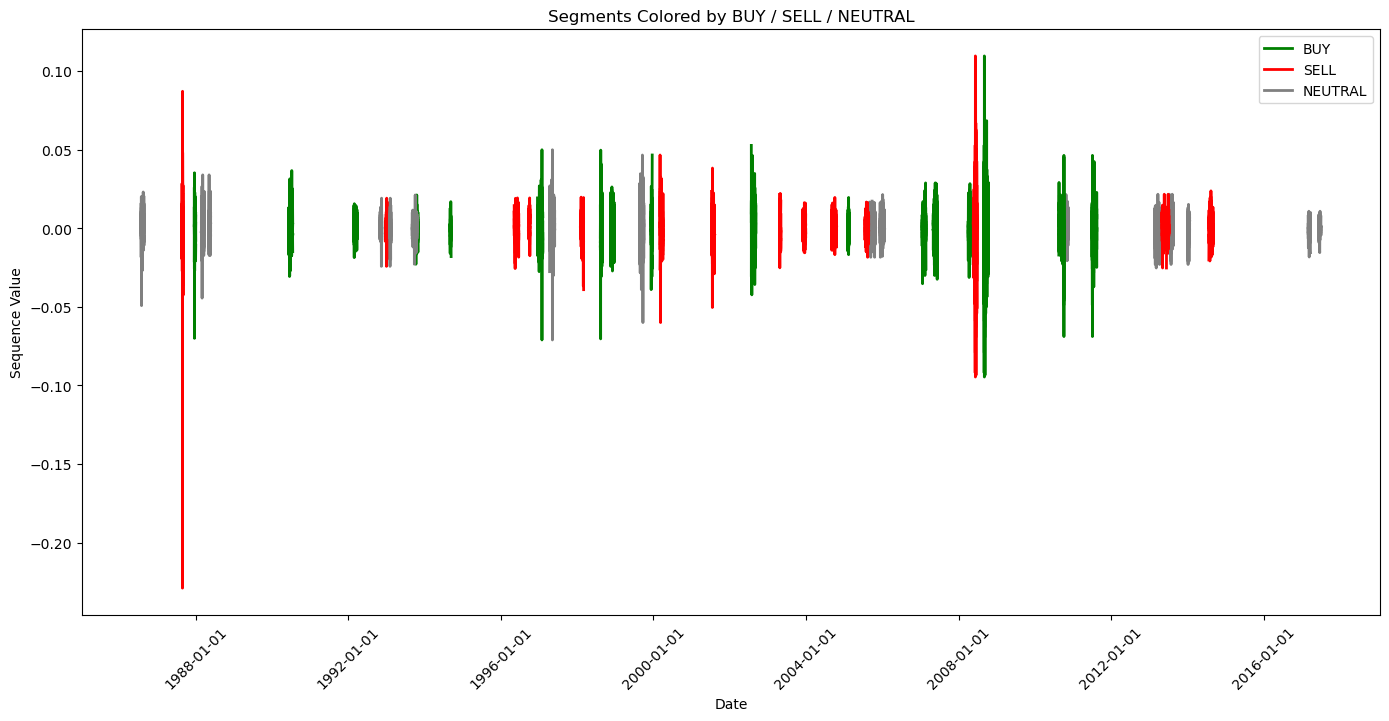

In [14]:
N = 50
df_plot = df_data.iloc[:N]

used_labels = set()

color_map = {
    "BUY": "green",
    "SELL": "red",
    "NEUTRAL": "gray"
}

plt.figure(figsize=(14,7))

for idx, row in df_plot.iterrows():
    seq = row['sequence']
    label = row['last_label']

    dates = pd.date_range(start=row['start_date'], periods=len(seq), freq="D")

    legend_label = label if label not in used_labels else "_nolegend_"
    used_labels.add(label)

    plt.plot(
        dates,
        seq,
        color=color_map.get(label, "black"),
        label=legend_label,
        linewidth=2
    )

plt.xlabel("Date")
plt.ylabel("Sequence Value")
plt.title("Segments Colored by BUY / SELL / NEUTRAL")

# --- FIX DUPLICATE LEGEND ENTRIES ---
handles, labels = plt.gca().get_legend_handles_labels()

seen = set()
new_handles = []
new_labels = []

for h, l in zip(handles, labels):
    if l == "_nolegend_":
        continue
    if l not in seen:
        new_handles.append(h)
        new_labels.append(l)
        seen.add(l)

plt.legend(new_handles, new_labels)
# ------------------------------------

plt.xticks(rotation=45)
plt.tight_layout()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()


In [15]:
def non_leaky_splits(df_sequences, 
                     train_frac=0.8, 
                     val_frac=0.1, 
                     test_frac=0.1):

    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-9

    # sort by end_date to enforce chronological order
    df = df_sequences.sort_values("end_date").reset_index(drop=True)

    # total timeline span (in rows, not tokens)
    total_len = df["length"].sum()

    # timeline cutoffs
    train_cut = total_len * train_frac
    val_cut   = total_len * (train_frac + val_frac)

    cumulative = 0
    split_labels = []

    for L in df["length"]:
        cumulative += L

        if cumulative <= train_cut:
            split_labels.append("train")
        elif cumulative <= val_cut:
            split_labels.append("val")
        else:
            split_labels.append("test")

    df["split"] = split_labels
    return df
df_data_non_leaked = non_leaky_splits(df_data)
df_data_non_leaked.head()

,sequence,labels,last_label,start_date,end_date,length,global_mean_pooling,global_last_state,subseries_mean_pooling,subseries_last_state,forecast,forecast_label,split
0,"[[0.0121623968046154, -0.008834638950921472, -...","[BUY, NEUTRAL, NEUTRAL, SELL, SELL, BUY, SELL,...",SELL,30-Mar-15,01-Apr-16,51,"[[tensor(0.0100, dtype=torch.float16), tensor(...","[[tensor(0.0140, dtype=torch.float16), tensor(...","[[tensor(0.0100, dtype=torch.float16), tensor(...","[[tensor(0.0140, dtype=torch.float16), tensor(...","[[0.002008074661716819, -0.0003346791199874133...",NEUTRAL,train
1,"[[-0.004936823039687194, 0.004768444524387738,...","[BUY, BUY, SELL, BUY, BUY, BUY, SELL, SELL, BU...",BUY,13-May-86,01-Apr-87,45,"[[tensor(-0.0065, dtype=torch.float16), tensor...","[[tensor(0.0136, dtype=torch.float16), tensor(...","[[tensor(-0.0065, dtype=torch.float16), tensor...","[[tensor(0.0136, dtype=torch.float16), tensor(...","[[0.0030976806301623583, 0.0024375165812671185...",BUY,train
2,"[[-0.001836090577596702, 0.004661433593708442,...","[SELL, BUY, SELL, SELL, SELL, SELL, BUY, SELL,...",BUY,11-Sep-90,01-Apr-91,28,"[[tensor(0.0040, dtype=torch.float16), tensor(...","[[tensor(0.0187, dtype=torch.float16), tensor(...","[[tensor(0.0040, dtype=torch.float16), tensor(...","[[tensor(0.0187, dtype=torch.float16), tensor(...","[[0.00012408049951773137, -0.00148896593600511...",NEUTRAL,train
3,"[[0.006374545191705185, 0.017343257004420746, ...","[BUY, SELL, BUY, SELL, BUY, SELL, SELL, BUY, B...",SELL,25-Mar-91,01-Apr-92,52,"[[tensor(0.0051, dtype=torch.float16), tensor(...","[[tensor(-0.0126, dtype=torch.float16), tensor...","[[tensor(0.0051, dtype=torch.float16), tensor(...","[[tensor(-0.0126, dtype=torch.float16), tensor...","[[-8.487664308631793e-05, -8.487664308631793e-...",NEUTRAL,train
4,"[[0.0014787998921436717, -0.00633851736236846,...","[BUY, NEUTRAL, NEUTRAL, SELL, SELL, BUY, BUY, ...",SELL,18-Oct-91,01-Apr-92,23,"[[tensor(0.0013, dtype=torch.float16), tensor(...","[[tensor(-0.0163, dtype=torch.float16), tensor...","[[tensor(0.0013, dtype=torch.float16), tensor(...","[[tensor(-0.0163, dtype=torch.float16), tensor...","[[-0.0002733934379648417, -0.00121073366608470...",NEUTRAL,train


In [16]:
class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X    # ndarray of list[tensor]
        self.y = y    # ndarray of list[int]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        seq_embs = self.X[idx]      # list of tensors (each: [embed_dim])
        seq_labels = self.y[idx]    # list of ints

        # stack token embeddings into [seq_len, embed_dim]
        X_tensor = torch.stack(seq_embs, dim=0)

        # convert labels to tensor
        y_tensor = torch.tensor(seq_labels, dtype=torch.long)

        return X_tensor, y_tensor


In [17]:
def pad_batch(batch):
    sequences, labels = zip(*batch)

    lengths = [s.size(0) for s in sequences]
    max_len = max(lengths)
    embed_dim = sequences[0].size(1)

    padded_x = torch.zeros(len(batch), max_len, embed_dim)
    padded_y = torch.full((len(batch), max_len), -100)  # ignored index
    mask = torch.zeros(len(batch), max_len, dtype=torch.bool)

    for i, (seq, lab) in enumerate(batch):
        L = seq.size(0)
        padded_x[i, :L] = seq
        padded_y[i, :L] = lab
        mask[i, :L] = 1

    return padded_x, padded_y, mask


In [18]:
import torch.nn as nn

class DeepTokenClassifier(nn.Module):
    def __init__(self, embed_dim, num_labels, hidden_dim=1024, num_layers=2, dropout=0.4):
        super().__init__()
        
        # Create a list of layers
        layers = []
        
        # First layer: Linear transformation
        layers.append(nn.Linear(embed_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        # Additional hidden layers
        for _ in range(num_layers - 1):  # num_layers-1 because the first layer is already added
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        # Final output layer
        layers.append(nn.Linear(hidden_dim, num_labels))
        
        # Create a sequential model from the list of layers
        self.classifier = nn.Sequential(*layers)
        
    def forward(self, x):
        # x: [batch, seq_len, embed_dim]
        # Pass through the classifier layers
        return self.classifier(x)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRF(nn.Module):
    def __init__(self, num_tags):
        super().__init__()
        self.num_tags = num_tags
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))

    def sequence_score(self, emissions, tags):
        score = torch.tensor(0.0, device=emissions.device)
        for i in range(len(tags)):
            score += emissions[i, tags[i]]
        for i in range(len(tags) - 1):
            score += self.transitions[tags[i], tags[i+1]]
        return score

    def log_sum_exp(self, x):
        max_score, _ = torch.max(x, dim=1)
        return max_score + torch.log(torch.sum(torch.exp(x - max_score.unsqueeze(1)), dim=1))

    def log_partition_function(self, emissions):
        alpha = emissions[0]
        for t in range(1, emissions.size(0)):
            scores = alpha.unsqueeze(1) + self.transitions + emissions[t].unsqueeze(0)
            alpha = self.log_sum_exp(scores)
        return torch.logsumexp(alpha, dim=0)

    def neg_log_likelihood(self, emissions, tags):
        gold = self.sequence_score(emissions, tags)
        log_Z = self.log_partition_function(emissions)
        return log_Z - gold

    def viterbi_decode(self, emissions):
        L, C = emissions.shape
        viterbi = torch.zeros(L, C).to(emissions.device)
        backpointer = torch.zeros(L, C, dtype=torch.long).to(emissions.device)

        viterbi[0] = emissions[0]

        for t in range(1, L):
            for next_tag in range(C):
                scores = viterbi[t-1] + self.transitions[:, next_tag]
                best_prev_tag = torch.argmax(scores)
                viterbi[t, next_tag] = scores[best_prev_tag] + emissions[t, next_tag]
                backpointer[t, next_tag] = best_prev_tag

        # backtrace
        best_last_tag = torch.argmax(viterbi[-1])
        best_path = [best_last_tag.item()]

        for t in reversed(range(1, L)):
            best_last_tag = backpointer[t, best_last_tag].item()
            best_path.append(best_last_tag)

        return list(reversed(best_path))


In [20]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    total_loss = 0

    for X, y, mask in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)  # [B, L, C]

        loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


<h2 style='color:#2c3e50;'>📏 Evaluation Functions for Sequence Classifiers</h2>

<p style='font-size:14px; line-height:1.6;'>
This section defines several evaluation utilities used to measure model quality.  
Because this is a <b>token-level</b> classification task over variable-length 
sequences, different accuracy definitions are needed:
</p>

<ul style='font-size:14px;'>
<li><b>Full-token accuracy</b>: evaluates every real token across sequences.</li>
<li><b>Last-token accuracy</b>: evaluates only the final token of each sequence 
    (proxy for next-window labeling accuracy).</li>
<li><b>All-but-last accuracy</b>: checks token predictions excluding the final 
    token, measuring internal sequence understanding.</li>
</ul>

<p style='font-size:14px; line-height:1.6;'>
These variants provide a richer understanding of model behavior than a 
single accuracy metric would.
</p>

In [21]:
@torch.no_grad()
def evaluate(model, loader, device, return_preds=False):
    model.eval()
    total_correct = 0
    total_tokens = 0

    all_preds = []
    all_targets = []

    for X, y, mask in loader:
        X = X.to(device)
        logits = model(X)
        preds = logits.argmax(dim=-1).cpu()
        total_correct += ((preds == y) * mask).sum().item()
        total_tokens += mask.sum().item()

        if return_preds:
            all_preds.append(preds[mask.bool()])
            all_targets.append(y[mask.bool()])

    acc = total_correct / total_tokens

    if return_preds:
        return acc, torch.cat(all_preds), torch.cat(all_targets)

    return acc

    
@torch.no_grad()
def evaluate_test_last_token(model, loader, device, return_preds=False):
    model.eval()

    total_correct = 0
    total_sequences = 0

    all_preds = []
    all_targets = []

    for X, y, mask in loader:
        X = X.to(device)

        logits = model(X)      # [B, L, C]
        preds = logits.argmax(dim=-1).cpu()   # [B, L]

        # -------------------------
        #   GET LAST TOKEN INDEX
        # -------------------------
        # mask: [B, L] -> True for real tokens
        lengths = mask.sum(dim=1)                  # [B]
        last_idx = lengths - 1                     # [B]
        batch_idx = torch.arange(len(lengths))     # [B]

        # -------------------------
        #   SELECT LAST TOKEN PRED + TARGET
        # -------------------------
        last_pred = preds[batch_idx, last_idx]     # [B]
        last_target = y[batch_idx, last_idx]       # [B]

        # -------------------------
        #   ACCURACY ONLY OVER LAST TOKEN
        # -------------------------
        total_correct += (last_pred == last_target).sum().item()
        total_sequences += len(last_pred)

        if return_preds:
            all_preds.append(last_pred)
            all_targets.append(last_target)

    acc = total_correct / total_sequences

    if return_preds:
        return acc, torch.cat(all_preds), torch.cat(all_targets)
    return acc

@torch.no_grad()
def evaluate_test_all_but_last_token(model, loader, device, return_preds=False):
    model.eval()

    total_correct = 0
    total_tokens = 0

    all_preds = []
    all_targets = []

    for X, y, mask in loader:
        X = X.to(device)

        logits = model(X)          # [B, L, C]
        preds = logits.argmax(dim=-1).cpu()   # [B, L]

        # -----------------------------------
        #   MASK: All real tokens EXCEPT last
        # -----------------------------------
        # mask: True for real tokens
        lengths = mask.sum(dim=1)             # [B]

        # Build a copy so we can zero-out last positions
        mask_no_last = mask.clone()

        # Zero-out the last token of each sequence
        for b in range(len(lengths)):
            last_idx = lengths[b] - 1
            mask_no_last[b, last_idx] = False

        # Apply the mask
        selected_preds = preds[mask_no_last]
        selected_targets = y[mask_no_last]

        # Accuracy
        total_correct += (selected_preds == selected_targets).sum().item()
        total_tokens += selected_preds.numel()

        if return_preds:
            all_preds.append(selected_preds)
            all_targets.append(selected_targets)

    acc = total_correct / total_tokens if total_tokens > 0 else 0.0

    if return_preds:
        return acc, torch.cat(all_preds), torch.cat(all_targets)
    return acc


<h2 style='color:#2c3e50;'>🔧 Data Preparation Utilities</h2>

<p style='font-size:14px; line-height:1.6;'>
This section provides helper functions that split the dataset into 
<b>train, validation, and test sets</b> and map string labels to integer IDs.
These utilities abstract away repetitive boilerplate, ensuring cleaner
experimental code and consistent label encoding.
</p>

<p style='font-size:14px; line-height:1.6;'>
Although simple, these functions are essential for ensuring that sequence labels 
are properly aligned and that model training receives the correct tensor format.
</p>

In [22]:
def prepare_splits(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    # Build vocab
    all_labels = sorted({l for seq in y for l in seq})
    label2id = {l: i for i, l in enumerate(all_labels)}

    N = len(X)
    N_train = int(0.8 * N)
    N_val   = int(0.1 * N)
    N_test  = N - N_train - N_val

    X_train = X[:N_train]
    y_train = y[:N_train]

    X_val = X[N_train:N_train+N_val]
    y_val = y[N_train:N_train+N_val]

    X_test = X[N_train+N_val:]
    y_test = y[N_train+N_val:]
    return X, y, X_train, y_train, X_val, y_val, X_test,y_test, label2id

    # dataset = EmbeddingDataset(X, y, label2id)
    # loader = torch.utils.data.DataLoader(dataset, batch_size=16, 
    #                                      shuffle=True, collate_fn=collate_fn)

# X, y, X_train, y_train, X_val, y_val, X_test,y_test = algo(df_data["global_mean_pooling"], df_data["labels"])

def encode_labels(y, y_train, y_val, y_test, label2id):
    # Build label mapping
    # unique_labels = sorted({l for seq in y for l in seq})
    # label2id = {label: i for i, label in enumerate(unique_labels)}

    # Convert labels to integer IDs
    y_train = [[label2id[l] for l in seq] for seq in y_train]
    y_val   = [[label2id[l] for l in seq] for seq in y_val]
    y_test  = [[label2id[l] for l in seq] for seq in y_test]

    num_labels = len(label2id)
    return y_train, y_val, y_test, num_labels



<h2 style='color:#2c3e50;'>🧪 Evaluate Different Chronos Pooling Strategies</h2>

<p style='font-size:14px; line-height:1.6;'>
Chronos produces token-level embeddings, but downstream performance depends heavily 
on how these embeddings are summarized. Here, we experiment with four strategies:
</p>

<ul style='font-size:14px;'>
<li><b>Global mean pooling</b></li>
<li><b>Global last token</b></li>
<li><b>Subseries mean pooling</b></li>
<li><b>Subseries last token</b></li>
</ul>

<p style='font-size:14px; line-height:1.6;'>
Each pooling method is fed into a neural classifier, trained for 20 epochs, and 
evaluated on token-level metrics. This helps determine which representation carries 
the most predictive information.
</p>

<p style='font-size:14px; line-height:1.6;'>
⚠️ This split is <b>index-based</b>, so it may contain data leakage.  
The fully non-leaky version comes later.

In [23]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import pandas as pd


poolings_to_test = {
    "global_mean_pooling": df_data["global_mean_pooling"], 
    "global_last_state": df_data["global_last_state"], 
    "subseries_mean_pooling": df_data["subseries_mean_pooling"], 
    "subseries_last_state": df_data["subseries_last_state"]
    }
labels = df_data["labels"]
leaked_values = []

for key in poolings_to_test.keys():
    print(f"testando pooling: {key}")
    X, y, X_train, y_train, X_val, y_val, X_test, y_test, label2id = prepare_splits(poolings_to_test[key], labels)
    y_train, y_val, y_test, num_labels = encode_labels(y, y_train, y_val, y_test, label2id)
    train_ds = TokenDataset(X_train, y_train)
    val_ds   = TokenDataset(X_val, y_val)
    test_ds  = TokenDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_batch)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=pad_batch)
    test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=pad_batch)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    embed_dim = X_train[0][0].numel()                # size of token embedding vector
    num_labels = len(set(l for seq in y_train for l in seq))

    model = DeepTokenClassifier(embed_dim, num_labels).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(20):
        loss = train_epoch(model, train_loader, optimizer, device)
        val_acc = evaluate(model, val_loader, device)
        # if epoch % 25 == 0:
        #     print(epoch, loss, val_acc)

    test_acc, test_preds, test_targets = evaluate_test_last_token(model, test_loader, device, return_preds=True)

    print("Test Accuracy for last token:", test_acc)

    # Compute classification metrics
    report = classification_report(
        test_targets.numpy(),
        test_preds.numpy(),
        output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()
    display(df_report)

    test_acc_all_but_last_token, test_preds_all_but_last_token, test_targets_all_but_last_token = evaluate_test_all_but_last_token(model, test_loader, device, return_preds=True)

    print("Test Accuracy for all but last token:", test_acc_all_but_last_token)

    # Compute classification metrics
    report = classification_report(
        test_targets_all_but_last_token.numpy(),
        test_preds_all_but_last_token.numpy(),
        output_dict=True
    )

    df_report_all_but_last_token = pd.DataFrame(report).transpose()
    display(df_report_all_but_last_token)
    leaked_values += [[df_report, df_report_all_but_last_token]]

testando pooling: global_mean_pooling
Test Accuracy for last token: 0.7019230769230769


,precision,recall,f1-score,support
0,0.634146,0.742857,0.684211,35.000000
1,0.742857,0.812500,0.776119,32.000000
2,0.750000,0.567568,0.646154,37.000000
accuracy,0.701923,0.701923,0.701923,0.701923
macro avg,0.709001,0.707642,0.702161,104.000000
weighted avg,0.708813,0.701923,0.698951,104.000000


Test Accuracy for all but last token: 0.9666212534059946


,precision,recall,f1-score,support
0,0.973840,0.971380,0.972609,1188.000000
1,0.947791,0.949062,0.948426,746.000000
2,0.972112,0.974052,0.973081,1002.000000
accuracy,0.966621,0.966621,0.966621,0.966621
macro avg,0.964581,0.964831,0.964705,2936.000000
weighted avg,0.966631,0.966621,0.966625,2936.000000


testando pooling: global_last_state
Test Accuracy for last token: 0.6153846153846154


,precision,recall,f1-score,support
0,0.611111,0.628571,0.619718,35.000000
1,0.589744,0.718750,0.647887,32.000000
2,0.655172,0.513514,0.575758,37.000000
accuracy,0.615385,0.615385,0.615385,0.615385
macro avg,0.618676,0.620278,0.614454,104.000000
weighted avg,0.620212,0.615385,0.612746,104.000000


Test Accuracy for all but last token: 0.9768392370572208


,precision,recall,f1-score,support
0,0.985605,0.979798,0.982693,1188.000000
1,0.953642,0.965147,0.959360,746.000000
2,0.984000,0.982036,0.983017,1002.000000
accuracy,0.976839,0.976839,0.976839,0.976839
macro avg,0.974416,0.975660,0.975024,2936.000000
weighted avg,0.976936,0.976839,0.976875,2936.000000


testando pooling: subseries_mean_pooling
Test Accuracy for last token: 0.6634615384615384


,precision,recall,f1-score,support
0,0.609756,0.714286,0.657895,35.000000
1,0.685714,0.750000,0.716418,32.000000
2,0.714286,0.540541,0.615385,37.000000
accuracy,0.663462,0.663462,0.663462,0.663462
macro avg,0.669919,0.668275,0.663232,104.000000
weighted avg,0.670316,0.663462,0.660778,104.000000


Test Accuracy for all but last token: 0.9594686648501363


,precision,recall,f1-score,support
0,0.956198,0.973906,0.964971,1188.000000
1,0.948016,0.928954,0.938389,746.000000
2,0.971859,0.965070,0.968453,1002.000000
accuracy,0.959469,0.959469,0.959469,0.959469
macro avg,0.958691,0.955977,0.957271,2936.000000
weighted avg,0.959464,0.959469,0.959405,2936.000000


testando pooling: subseries_last_state
Test Accuracy for last token: 0.625


,precision,recall,f1-score,support
0,0.625000,0.714286,0.666667,35.000
1,0.636364,0.656250,0.646154,32.000
2,0.612903,0.513514,0.558824,37.000
accuracy,0.625000,0.625000,0.625000,0.625
macro avg,0.624756,0.628016,0.623881,104.000
weighted avg,0.624193,0.625000,0.621988,104.000


Test Accuracy for all but last token: 0.9737738419618529


,precision,recall,f1-score,support
0,0.988917,0.976431,0.982634,1188.000000
1,0.936611,0.970509,0.953259,746.000000
2,0.984848,0.973054,0.978916,1002.000000
accuracy,0.973774,0.973774,0.973774,0.973774
macro avg,0.970125,0.973331,0.971603,2936.000000
weighted avg,0.974238,0.973774,0.973901,2936.000000


<h2 style='color:#2c3e50;'>⛓️ Refined Non-Leaky Splits for Chronological Separation</h2>

<p style='font-size:14px; line-height:1.6;'>
This improved version of the non-leaky splitter sorts all sequences by their 
<b>end date</b> and allocates them to train/val/test based on cumulative timeline length.  
This ensures:
</p>

<ul style='font-size:14px;'>
<li>Training uses only past data</li>
<li>Validation uses future-but-near data</li>
<li>Testing uses the most recent unseen data</li>
</ul>

<p style='font-size:14px;'>  
This avoids temporal leakage and produces a realistic forward-looking evaluation setup.
</p>

In [24]:
def encode_two_label_columns_shared_mapping(df, col1, col2):
    """
    Encode two columns that contain SINGLE labels (strings),
    like 'buy', 'neutral', 'sell'.
    """

    # get unique full labels (not characters)
    all_labels = sorted(set(df[col1].unique()) | set(df[col2].unique()))

    label2id = {label: i for i, label in enumerate(all_labels)}

    df[col1 + "_encoded"] = df[col1].map(label2id)
    df[col2 + "_encoded"] = df[col2].map(label2id)

    return df, label2id




def create_non_leaky_splits(df_sequences, 
                     train_frac=0.8, 
                     val_frac=0.1, 
                     test_frac=0.1):

    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-9
    
    # sort by end_date to enforce chronological order
    df = df_sequences.sort_values("end_date").reset_index(drop=True)

    # total timeline span (in rows, not tokens)
    total_len = df["length"].sum()

    # timeline cutoffs
    train_cut = total_len * train_frac
    val_cut   = total_len * (train_frac + val_frac)

    cumulative = 0
    split_labels = []

    for L in df["length"]:
        cumulative += L

        if cumulative <= train_cut:
            split_labels.append("train")
        elif cumulative <= val_cut:
            split_labels.append("val")
        else:
            split_labels.append("test")

    df["split"] = split_labels
    return df



<h2 style='color:#2c3e50;'>📦 Apply Non-Leaky Train/Val/Test Splits</h2>

<p style='font-size:14px; line-height:1.6;'>
After identifying which rows belong to train/val/test splits, we extract the 
corresponding feature sequences and label sequences. This produces clean, 
chronologically-separated datasets for model training.
</p>

<p style='font-size:14px; line-height:1.6;'>
We then convert all string labels to integer IDs using a joint mapping, ensuring 
consistency across all splits.
</p>

In [25]:


def prepare_splits_non_leaky(X, y, df_splits):
    """
    X: a pd.Series of features (must align with df_splits index)
    y: a pd.Series of labels (must align with df_splits index)
    df_splits: dataframe containing the 'split' column created by non_leaky_splits
    """

    # Ensure array format (optional)
    X = X.to_numpy()
    y = y.to_numpy()
    split = df_splits.to_numpy()

    # Boolean masks
    train_mask = split == "train"
    val_mask   = split == "val"
    test_mask  = split == "test"

    # Now just index by mask
    X_train = X[train_mask]
    y_train = y[train_mask]

    X_val = X[val_mask]
    y_val = y[val_mask]

    X_test = X[test_mask]
    y_test = y[test_mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test


def encode_labels_non_leaky(y, y_train, y_val, y_test, label2id):
    # Convert labels to integer IDs
    y_train = [[label2id[l] for l in seq] for seq in y_train]
    y_val   = [[label2id[l] for l in seq] for seq in y_val]
    y_test  = [[label2id[l] for l in seq] for seq in y_test]

    num_labels = len(label2id)
    return y_train, y_val, y_test, num_labels


<h2 style='color:#2c3e50;'>🧪 Compare Pooling Strategies Under Non-Leaky Splits</h2>

<p style='font-size:14px; line-height:1.6;'>
This section repeats the earlier pooling experiment, but now using 
<b>chronologically correct non-leaky splits</b>.  
This eliminates unrealistic leakage and simulates how the model would 
perform in a real trading or forecasting environment.
</p>

<ul style='font-size:14px;'>
<li>train → oldest sequences</li>
<li>val → middle sequences</li>
<li>test → most recent sequences</li>
</ul>

<p style='font-size:14px; line-height:1.6;'>
Each pooling strategy is trained for 20 epochs and evaluated using:
</p>
<ul style='font-size:14px;'>
<li><b>Last-token accuracy</b></li>
<li><b>All-but-last token accuracy</b></li>
<li><b>Full classification report (precision/recall/F1)</b></li>
</ul>

In [26]:
# Execute non-leaky split creation and inspect outputs

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import pandas as pd

df_data_non_leaked = create_non_leaky_splits(df_data)
df_data_non_leaked, label2id = encode_two_label_columns_shared_mapping(df_data_non_leaked, "last_label", "forecast_label")
poolings_to_test = {
    "global_mean_pooling": df_data_non_leaked["global_mean_pooling"], 
    "global_last_state": df_data_non_leaked["global_last_state"], 
    "subseries_mean_pooling": df_data_non_leaked["subseries_mean_pooling"], 
    "subseries_last_state": df_data_non_leaked["subseries_last_state"]
}
labels = df_data_non_leaked["labels"]
split =  df_data_non_leaked["split"]
non_leaked_values = []

for key in poolings_to_test.keys():
    print(f"testando pooling: {key}")
    X, y, X_train, y_train, X_val, y_val, X_test,y_test = prepare_splits_non_leaky(poolings_to_test[key], labels, split)
    y_train, y_val, y_test, num_labels = encode_labels_non_leaky(y, y_train, y_val, y_test, label2id)
    train_ds = TokenDataset(X_train, y_train)
    val_ds   = TokenDataset(X_val, y_val)
    test_ds  = TokenDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_batch)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=pad_batch)
    test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=pad_batch)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    embed_dim = X_train[0][0].numel()                # size of token embedding vector
    num_labels = len(set(l for seq in y_train for l in seq))

    model = DeepTokenClassifier(embed_dim, num_labels).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(20):
        loss = train_epoch(model, train_loader, optimizer, device)
        val_acc = evaluate(model, val_loader, device)


    test_acc, test_preds, test_targets = evaluate_test_last_token(model, test_loader, device, return_preds=True)

    print("Test Accuracy for last token:", test_acc)

    # Compute classification metrics
    report = classification_report(
        test_targets.numpy(),
        test_preds.numpy(),
        output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()
    display(df_report)

    test_acc_all_but_last_token, test_preds_all_but_last_token, test_targets_all_but_last_token = evaluate_test_all_but_last_token(model, test_loader, device, return_preds=True)

    print("Test Accuracy for all but last token:", test_acc_all_but_last_token)

    # Compute classification metrics
    report = classification_report(
        test_targets_all_but_last_token.numpy(),
        test_preds_all_but_last_token.numpy(),
        output_dict=True
    )

    df_report_all_but_last_token = pd.DataFrame(report).transpose()
    display(df_report_all_but_last_token)
    non_leaked_values += [[df_report, df_report_all_but_last_token]]

testando pooling: global_mean_pooling
Test Accuracy for last token: 0.49504950495049505


,precision,recall,f1-score,support
0,0.424242,0.424242,0.424242,33.00000
1,0.636364,0.617647,0.626866,34.00000
2,0.428571,0.441176,0.434783,34.00000
accuracy,0.495050,0.495050,0.495050,0.49505
macro avg,0.496392,0.494355,0.495297,101.00000
weighted avg,0.497107,0.495050,0.496000,101.00000


Test Accuracy for all but last token: 0.9661726804123711


,precision,recall,f1-score,support
0,0.975705,0.966615,0.971139,1288.000000
1,0.941846,0.953905,0.947837,781.000000
2,0.972999,0.974879,0.973938,1035.000000
accuracy,0.966173,0.966173,0.966173,0.966173
macro avg,0.963517,0.965133,0.964305,3104.000000
weighted avg,0.966284,0.966173,0.966209,3104.000000


testando pooling: global_last_state
Test Accuracy for last token: 0.4752475247524752


,precision,recall,f1-score,support
0,0.395349,0.515152,0.447368,33.000000
1,0.594595,0.647059,0.619718,34.000000
2,0.428571,0.264706,0.327273,34.000000
accuracy,0.475248,0.475248,0.475248,0.475248
macro avg,0.472838,0.475639,0.464786,101.000000
weighted avg,0.473606,0.475248,0.464959,101.000000


Test Accuracy for all but last token: 0.9835695876288659


,precision,recall,f1-score,support
0,0.989097,0.986025,0.987558,1288.00000
1,0.976774,0.969270,0.973008,781.00000
2,0.981818,0.991304,0.986538,1035.00000
accuracy,0.983570,0.983570,0.983570,0.98357
macro avg,0.982563,0.982200,0.982368,3104.00000
weighted avg,0.983569,0.983570,0.983557,3104.00000


testando pooling: subseries_mean_pooling
Test Accuracy for last token: 0.5445544554455446


,precision,recall,f1-score,support
0,0.517241,0.454545,0.483871,33.000000
1,0.600000,0.705882,0.648649,34.000000
2,0.500000,0.470588,0.484848,34.000000
accuracy,0.544554,0.544554,0.544554,0.544554
macro avg,0.539080,0.543672,0.539123,101.000000
weighted avg,0.539297,0.544554,0.539670,101.000000


Test Accuracy for all but last token: 0.9623067010309279


,precision,recall,f1-score,support
0,0.973312,0.962733,0.967994,1288.000000
1,0.921760,0.965429,0.943089,781.000000
2,0.981225,0.959420,0.970200,1035.000000
accuracy,0.962307,0.962307,0.962307,0.962307
macro avg,0.958766,0.962527,0.960428,3104.000000
weighted avg,0.962980,0.962307,0.962463,3104.000000


testando pooling: subseries_last_state
Test Accuracy for last token: 0.40594059405940597


,precision,recall,f1-score,support
0,0.375000,0.363636,0.369231,33.000000
1,0.531250,0.500000,0.515152,34.000000
2,0.324324,0.352941,0.338028,34.000000
accuracy,0.405941,0.405941,0.405941,0.405941
macro avg,0.410191,0.405526,0.407470,101.000000
weighted avg,0.410540,0.405941,0.407849,101.000000


Test Accuracy for all but last token: 0.9813144329896907


,precision,recall,f1-score,support
0,0.989867,0.986025,0.987942,1288.000000
1,0.977778,0.957746,0.967658,781.000000
2,0.973485,0.993237,0.983262,1035.000000
accuracy,0.981314,0.981314,0.981314,0.981314
macro avg,0.980377,0.979003,0.979621,3104.000000
weighted avg,0.981363,0.981314,0.981278,3104.000000


In [27]:
print("Test prediction based on prediction and manual labeling in leaked dataset")

# Compute classification metrics
report = classification_report(
    df_data["last_label"].to_numpy(),
    df_data["forecast_label"].to_numpy(),
    output_dict=True
)

df_predicted_leaked = pd.DataFrame(report).transpose()
display(df_predicted_leaked)

print("Test prediction based on prediction and manual labeling in non leaked dataset")

# Compute classification metrics
report = classification_report(
    df_data_non_leaked["last_label"].to_numpy(),
    df_data_non_leaked["forecast_label"].to_numpy(),
    output_dict=True
)

df_predicted_non_leaked = pd.DataFrame(report).transpose()
display(df_predicted_non_leaked)

Test prediction based on prediction and manual labeling in leaked dataset


,precision,recall,f1-score,support
BUY,0.372951,0.264535,0.309524,344.000000
NEUTRAL,0.377072,0.793605,0.511236,344.000000
SELL,0.453125,0.084302,0.142157,344.000000
accuracy,0.380814,0.380814,0.380814,0.380814
macro avg,0.401049,0.380814,0.320972,1032.000000
weighted avg,0.401049,0.380814,0.320972,1032.000000


Test prediction based on prediction and manual labeling in non leaked dataset


,precision,recall,f1-score,support
BUY,0.372951,0.264535,0.309524,344.000000
NEUTRAL,0.377072,0.793605,0.511236,344.000000
SELL,0.453125,0.084302,0.142157,344.000000
accuracy,0.380814,0.380814,0.380814,0.380814
macro avg,0.401049,0.380814,0.320972,1032.000000
weighted avg,0.401049,0.380814,0.320972,1032.000000
